In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import math
import os

In [3]:
# Import the listing of block groups
block_groups_path = os.path.join(os.path.dirname(os.path.abspath('..')), 'datasets', 'block_groups_nb.json')
block_groups = gpd.read_file(block_groups_path)
# Import the list of coordinates of field incident reports
incident_points_path = os.path.join(os.path.dirname(os.path.abspath('..')), 'datasets', 'incident_points_nb.json')
incident_points = gpd.read_file(incident_points_path)
# Import the list of public housing locations
ps_locs_path = os.path.join(os.path.dirname(os.path.abspath('..')), 'datasets', 'nb_public_schools_final.csv')
public_schools_locations = pd.read_csv(ps_locs_path)

In [4]:
# Add a proper geometric object to each row of the public schools list so we can plot these locations
public_schools_locations['shapely.geometry.Point'] = public_schools_locations.apply(lambda x: Point(x['Longitude'],x['Latitude']), axis=1)

In [5]:
# Calculate the approximate distance (in miles) between two points based on their longitudes and latitudes
# Needed info on the Earth's radius -- came from https://rechneronline.de/earth-radius/
# Formula used comes from https://en.wikipedia.org/wiki/Haversine_formula#Formulation
def haversine_distance(point1, point2):
    ''' Calculate the distance between two points based on latitude and longitude.
        input: two shapely.geometry.Point objects
        output: float distance (in miles)
    '''
    # Need to convert lat/long to radians for this to work
    point1_lat = point1.y * math.pi / 180
    point1_long = point1.x * math.pi / 180
    point2_lat = point2.y * math.pi / 180
    point2_long = point2.x * math.pi / 180
    # Uses the well-known Haversine formula (not perfect, but a pretty good approximation)
    inner_term = math.sin((point2_lat - point1_lat)/2)**2 + math.cos(point1_lat) * math.cos(point2_lat) * \
         math.sin((point2_long - point1_long)/2) ** 2
    distance = 2 * 3957.52 * math.asin(inner_term ** 0.5)
    return distance

In [6]:
# Function for finding the number of incidents that occurred within x miles of a particular point
def incidents_within_radius(point, incidents, radius):
    distances_to_point = incidents.apply(lambda x: haversine_distance(x[0], point),axis=1)
    return (distances_to_point[distances_to_point <= radius]).count()

In [7]:
# For each public housing location, calculate how many incidents occurred within a certain radius of it
public_schools_locations['Incidents Within 0.1 Miles'] = public_schools_locations.apply(lambda x: incidents_within_radius(point=x['shapely.geometry.Point'],incidents=incident_points,radius=0.1),axis=1)
public_schools_locations['Incidents Within 0.25 Miles'] = public_schools_locations.apply(lambda x: incidents_within_radius(point=x['shapely.geometry.Point'],incidents=incident_points,radius=0.25),axis=1)
public_schools_locations['Incidents Within 0.5 Miles'] = public_schools_locations.apply(lambda x: incidents_within_radius(point=x['shapely.geometry.Point'],incidents=incident_points,radius=0.5),axis=1)

In [8]:
# Grab the list of Point objects from the list of public schools
schools_points = gpd.GeoSeries(public_schools_locations['shapely.geometry.Point'])

# Set up a GeoPandas Coordinate Reference System for the incident locations, in order to match it with the map of New Bedford
schools_points_crs = schools_points.set_crs(crs=block_groups.crs)

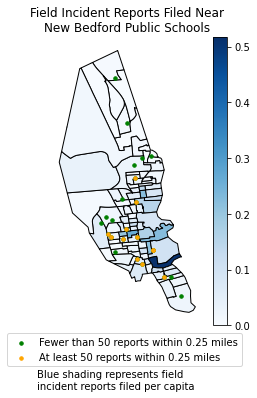

In [9]:
# Now, we plot the locations of New Bedford's public schools along with how many incidents occurred near each school
incident_radius_figure = plt.figure()
axes = incident_radius_figure.add_axes([0,0,0.5,1])

the_plot = block_groups.plot(column='Incidents Per Capita',cmap='Blues',edgecolor='black',axes=axes,legend=True)
schools_points.plot(ax=axes, marker="o",color='green',markersize=12,label='Fewer than 50 reports within 0.25 miles')

geq_50_in_quarter_mile = schools_points[public_schools_locations['Incidents Within 0.25 Miles']>=50]
geq_50_in_quarter_mile.plot(ax=axes,marker="o",color='orange',markersize=12,label='At least 50 reports within 0.25 miles')
# This ends up being unnecessary because, unlike with the public housing locations, none of the public schools have over 50
# reports within 0.1 miles of their addresses
geq_50_in_tenth_of_mile = schools_points[public_schools_locations['Incidents Within 0.1 Miles']>=50]
geq_50_in_tenth_of_mile.plot(ax=axes,marker="o",color='red',markersize=12,label='At least 50 reports within 0.1 miles')

axes.legend(bbox_to_anchor=[1.2,-0.11,0.1,0.1])

axes.set_title('Field Incident Reports Filed Near\nNew Bedford Public Schools')
axes.axis('off')
axes.text(x=-0.1,y=-0.22,s='Blue shading represents field\nincident reports filed per capita',transform=axes.transAxes)
incident_radius_figure.tight_layout()
incident_radius_figure.show()

## Just like in the public housing analysis, we'll finish this off by computing some summary numbers

In [12]:
# Print some summary numbers about how many incidents happened near public schools
# This requires checking every single one of the 4997 incidents to see if it occurred near any public schools
within_tenth_of_mile = [False for i in range(4997)]
within_quarter_of_mile = [False for i in range(4997)]
within_half_of_mile = [False for i in range(4997)]
incident_points['Within 0.1 Miles of Public Schools'] = within_tenth_of_mile
incident_points['Within 0.25 Miles of Public Schools'] = within_quarter_of_mile
incident_points['Within 0.5 Miles of Public Schools'] = within_half_of_mile
for i in incident_points.index:
    for j in public_schools_locations.index:
        dist = haversine_distance(incident_points.iloc[i]['geometry'],public_schools_locations.iloc[j]['shapely.geometry.Point'])
        if dist <= 0.1:
            incident_points.at[i,'Within 0.1 Miles of Public Schools'] = True
            incident_points.at[i,'Within 0.25 Miles of Public Schools'] = True
            incident_points.at[i,'Within 0.5 Miles of Public Schools'] = True
            break
        elif dist <= 0.25:
            incident_points.at[i,'Within 0.1 Miles of Public Schools'] = False
            incident_points.at[i,'Within 0.25 Miles of Public Schools'] = True
            incident_points.at[i,'Within 0.5 Miles of Public Schools'] = True
        elif dist <= 0.5:
            if incident_points.iloc[i]['Within 0.25 Miles of Public Schools'] == True:
                continue
            incident_points.at[i,'Within 0.1 Miles of Public Schools'] = False
            incident_points.at[i,'Within 0.25 Miles of Public Schools'] = False
            incident_points.at[i,'Within 0.5 Miles of Public Schools'] = True
        else:
            continue

In [13]:
# Get the final summary statistics about how many incidents occurred near public schools
print('Proportion of incidents within 0.1 miles of public schools:')
print(incident_points['Within 0.1 Miles of Public Schools'].sum() / 4997)
print('Proportion of incidents within 0.25 miles of public schools:')
print(incident_points['Within 0.25 Miles of Public Schools'].sum() / 4997)
print('Proportion of incidents within 0.5 miles of public schools:')
print(incident_points['Within 0.5 Miles of Public Schools'].sum() / 4997)

Proportion of incidents within 0.1 miles of public schools:
0.046427856714028416
Proportion of incidents within 0.25 miles of public schools:
0.3678206924154493
Proportion of incidents within 0.5 miles of public schools:
0.90074044426656
